In [1]:
# Imports

# Used For Data Frames
import pandas as pd 

# Used to load email files
import os 

# Used for email file formats & extracting email content
import email
from email import policy
from bs4 import BeautifulSoup

In [2]:
# Print size of data
print("Size of Spam Data:", len(os.listdir('./Data/archive/spam/')))
print("Size of Ham Data:", len(os.listdir('./Data/archive/ham/')))

Size of Spam Data: 501
Size of Ham Data: 2551


In [3]:
# Import Raw Data

# Local directory that the data is stored in
directory = './Data/archive/'

# Email Contents
contents = []
subject = []
labels = []
fromSenders = []

# Count LookupErrors & Unsupported Content Types
errors = 0
wrongRootContentTypes = 0
wrongChildContentTypes = 0

# For Multipart email types, need to recursively get content
def payloadToContent(payload):
    finalContent = ""
    # For each sub-email in email
    for i in range(len(payload)):
        try:
            #If String add to finalContent
            if(isinstance(payload[i], str)):
                finalContent += payload[i]
            #If plain text add content to finalContent
            elif payload[i].get_content_type() == 'text/plain':
                finalContent += payload[i].get_content()
            #If html add body to finalContent
            elif payload[i].get_content_type() == 'text/html':
                finalContent += BeautifulSoup(payload[i].get_content()).body.text
            #If multipart - recursively run this method
            elif "multipart" in payload[i].get_content_type():
                finalContent += payloadToContent(payload[i].get_payload())
            # Else - unsupported type (such as signature) - ignore 
            else:
                global wrongChildContentTypes 
                wrongChildContentTypes += 1
        except LookupError:
            errors += 1
            pass
    return finalContent

# Loop through ham & spam folder
for label in ['ham/', 'spam/']:
    labelDirectory = os.listdir(directory + label)
    # For each file in direectory
    for file in labelDirectory:
        # Read file (rb) as bytes
        with open((directory + label + file), 'rb') as file:
            # Parse bytes into email, using default email policy
            email_file = email.parser.BytesParser(policy=email.policy.default).parse(file)
            try:
                #If plain text - add content
                if email_file.get_content_type() == 'text/plain':
                    contents.append(email_file.get_content())
                #If html - parse to html and add the html's body
                elif email_file.get_content_type() == 'text/html':
                    contents.append(BeautifulSoup(email_file.get_content()).body.text)
                #If multipart - get payload and run payloadToContent()
                elif email_file.get_content_type() in ['multipart/signed', 'multipart/mixed', 'multipart/report', 'multipart/related', 'multipart/alternative']:
                    contents.append(payloadToContent(email_file.get_payload()))
                # Else - Unsupported content type
                else:
                    wrongRootContentTypes += 1
                    continue
                # Add Subject, Label & From Sender
                subject.append(email_file['Subject'] or "")
                labels.append(label)
                fromSenders.append(email_file['From'] or "")
            except LookupError:
                errors +=1
                pass
            
print("Read Email Content Errors: " + str(errors))
print("Wrong Email Root Content Type: " + str(wrongRootContentTypes))
print("Wrong Email Child Content Type: " + str(wrongChildContentTypes))

Read Email Content Errors: 3
Wrong Email Root Content Type: 0
Wrong Email Child Content Type: 94


In [4]:
# Convert to Dataframe
df = pd.DataFrame({'subject': subject, 'content': contents, 'label': labels, 'from': fromSenders})
df.head()

,subject,content,label,from
0,Re: New Sequences Window,"Date: Wed, 21 Aug 2002 10:54:46 -05...",ham/,Robert Elz <kre@munnari.OZ.AU>
1,[zzzzteana] RE: Alexander,"Martin A posted:\nTassos Papadopoulos, the Gre...",ham/,Steve Burt <Steve_Burt@cursor-system.com>
2,[zzzzteana] Moscow bomber,Man Threatens Explosion In Moscow \n\nThursday...,ham/,Tim Chapman <timc@2ubh.com>
3,[IRR] Klez: The Virus That Won't Die,Klez: The Virus That Won't Die\n \nAlready the...,ham/,Monty Solomon <monty@roscom.com>
4,Re: Insert signature,"On Wed Aug 21 2002 at 15:46, Ulises Ponce wrot...",ham/,Tony Nugent <tony@linuxworks.com.au>


In [5]:
# Encoder 
from sklearn.preprocessing import LabelEncoder

#Vectorizer 
from sklearn.feature_extraction.text import CountVectorizer

# Regex
import re

# Natural Language Toolkit for Stemmer
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')

# Progress Bar
from ipywidgets import IntProgress
from IPython.display import display

# Arrays
import numpy as np


columnArray = ['content', 'from', 'subject']

def processDf(df):
    # Encode Labels
    encoder = LabelEncoder()
    df['label'] = encoder.fit_transform(df['label'])
    
    #To lower every column & remove new line characters
    for column in columnArray:
        df[column] = df[column].apply(lambda x:x.lower())
        df[column] = df[column].apply(lambda x: x.replace('\n', ' '))
        df[column] = df[column].apply(lambda x: x.replace('\t', ' '))
        df[column] = df[column].apply(lambda x: x.replace('\r', ' '))
    
    # Word Stemming & Regex to characters only
    ps = PorterStemmer()
    
    combined = []

    #Display progress bar
    progress = IntProgress(min=0, max=len(df))
    display(progress)
    
    # For each email in list
    for i in range(len(df)):
        # update progress bar
        progress.value = i
        
        processedRows = []
        #For each column in email
        for column in columnArray:
            # Remove special charactors & numbers - uses Regex
            review = re.sub('[^a-zA-Z]', ' ', df[column][i])
            review = review.split()
            # Get the stem of the word if the word is not in StopWords (a, on, at, to, and ...) 
            review = [ps.stem(word) for word in review if word not in stopwords.words('english')]
            review = ' '.join(review)
            processedRows.append(review)    
        combined.append(processedRows)
    return combined

# Train a vectoriser to convert list of words into word count vector (with max size of features count)
def trainVectorise(processed, featuresCount):
    array = np.array(processed)
    
    contentCv = CountVectorizer(max_features = featuresCount)
    contentVector =  contentCv.fit_transform(array[:,0]).toarray()
    
    fromCv = CountVectorizer(max_features = featuresCount)
    fromVector =  fromCv.fit_transform(array[:,1]).toarray()
    
    subjectCv = CountVectorizer(max_features = featuresCount)
    subjectVector =  subjectCv.fit_transform(array[:,2]).toarray()
    
    vector = np.concatenate((contentVector, fromVector,subjectVector), axis=1)
    
    return vector, contentCv, fromCv, subjectCv

# Use a pre-trained count vectorizer to vectorise a list of words
def vectorise(processed, contentCv, fromCv, subjectCv):
    array = np.array(processed)
    contentVector =  contentCv.transform(array[:,0]).toarray()
    fromVector =  fromCv.transform(array[:,1]).toarray()
    subjectVector =  subjectCv.transform(array[:,2]).toarray()
    vector = np.concatenate((contentVector, fromVector,subjectVector), axis=1)
    return vector

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rgaud\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# Process the Data frame
processed = processDf(df)

IntProgress(value=0, max=3049)

In [7]:
processed[0]

['date wed aug chri garrigu cwg date fa deepeddi com messag id tmda deepeddi vircio com reproduc error repeat like everi time without fail debug log pick happen pick exec pick inbox list lbrace lbrace subject ftp rbrace rbrace sequenc mercuri exec pick inbox list lbrace lbrace subject ftp rbrace rbrace sequenc mercuri ftoc pickmsg hit mark hit tkerror syntax error express int note run pick command hand delta pick inbox list lbrace lbrace subject ftp rbrace rbrace sequenc mercuri hit hit come obvious version nmh use delta pick version pick nmh compil fuchsia cs mu oz au sun mar ict relev part mh profil delta mhparam pick seq sel list sinc pick command work sequenc actual one explicit command line search popup one come mh profil get creat kre ps still use version code form day ago abl reach cv repositori today local rout issu think exmh worker mail list exmh worker redhat com http listman redhat com mailman listinfo exmh worker',
 'robert elz kre munnari oz au',
 'new sequenc window']

In [8]:
# Vectorise the processed results (max word count of 3000)
vectorResults = trainVectorise(processed, 3000)

# Bag of Words 3000
bow3000 = vectorResults[0]
vectorContentModel = vectorResults[1]
vectorFromModel = vectorResults[2]
vectorSubjectModel = vectorResults[3]
labels = df['label']

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB


def trainNaiveBayes(bowVector, labels):
    # Split to train & test set
    x_train, x_test, y_train, y_test = train_test_split(bowVector, labels, test_size = 0.2, random_state = 42)
    
    # Algorithm - MultiNomial Naive Bayes
    model = MultinomialNB()
    # Fit to training data
    model.fit(x_train, y_train)
    #Predict Test Data
    y_pred = model.predict(x_test)
    # Return actual results, predicted results and the final model
    return y_test, y_pred, model

# Train Naive Bayes with 3000 feature vector
resultNB3000 = trainNaiveBayes(bow3000, labels)

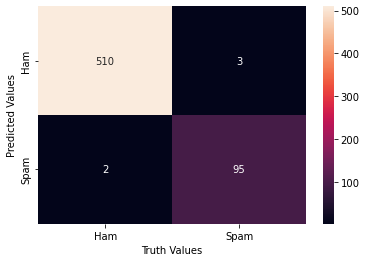

Accuracy: 99.18%
Precision: 96.94%
Recall: 97.94%
F1 score: 97.44%


In [10]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

def getMetrics(y_test, y_pred):
    # Get confusion metric (how many correct, incorrect)
    matrix = confusion_matrix(y_test, y_pred)

    #Plot confusion metric to heatmap
    s = sns.heatmap(matrix, annot=True, fmt='.3g', xticklabels=["Ham", "Spam"], yticklabels=["Ham", "Spam"])
    s.set(xlabel='Truth Values', ylabel='Predicted Values')
    plt.show()

    # Print Metrics
    print("Accuracy: {:.2f}%".format(100 * accuracy_score(y_test, y_pred)))
    print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_pred)))
    print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_pred)))
    print("F1 score: {:.2f}%".format(100 * f1_score(y_test, y_pred)))

getMetrics(resultNB3000[0], resultNB3000[1])

In [11]:
# Test trainNaiveBayes for multiple max feature sizes
def testBagOfWords(start, end, step):
    f2 = IntProgress(min=start, max=end) # instantiate the bar
    display(f2) # display the bar
    result = []
    for fi in range(start, end, step):
        f2.value = fi
        vectorresults = trainVectorise(processed, fi)
        nbResults = trainNaiveBayes(vectorresults[0], labels)
        f1score = f1_score(nbResults[0], nbResults[1])
        accuracyscore = accuracy_score(nbResults[0], nbResults[1])
        result.append([fi, f1score, accuracyscore])
    return result

#Plot results (accuracy & f1 score) from testBagOfWords
def plotBagOfWordsResult(results, removefromfront):
    resultsX = [i[0] for i in results]
    resultsYF1 = [i[1] for i in results]
    resultsYAccuracy = [i[2] for i in results]

    n = removefromfront

    plt.plot(resultsX[n:], resultsYF1[n:], color='r', label='f1 score')
    plt.plot(resultsX[n:], resultsYAccuracy[n:], color='g', label='accuracy')

    plt.xlabel("Bag of Words Size")
    plt.ylabel("Metric")
    plt.title("F1 & Accuracy")

    plt.legend()
    plt.show() 

IntProgress(value=1, max=30002, min=1)

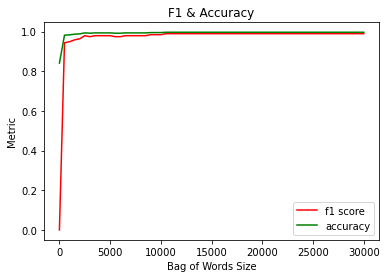

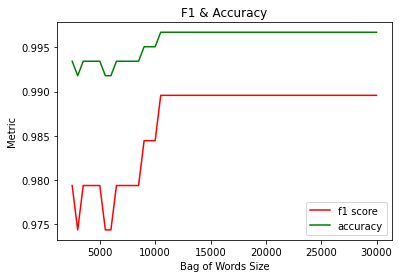

In [12]:
# Test Bag of Word Sizes between 1 & 30002 in increments of 100 
bagOfWordsSizeCourseResults = testBagOfWords(1, 30002, 500)

# Plot results of test
plotBagOfWordsResult(bagOfWordsSizeCourseResults, 0)

# Plot again without first 5 elements (to view results better)
plotBagOfWordsResult(bagOfWordsSizeCourseResults, 5)

IntProgress(value=10000, max=12000, min=10000)

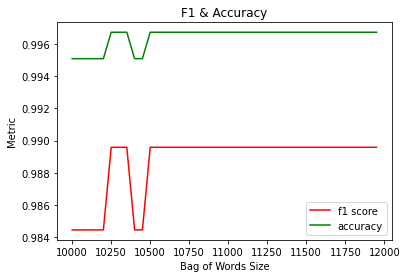

In [13]:
# Rerun Bag of Words Tests between 10,000 & 12,000 in a smaller increment of 50
bagOfWordsSizeFineResults = testBagOfWords(10000, 12000, 50)
# Plot results of test
plotBagOfWordsResult(bagOfWordsSizeFineResults, 0)

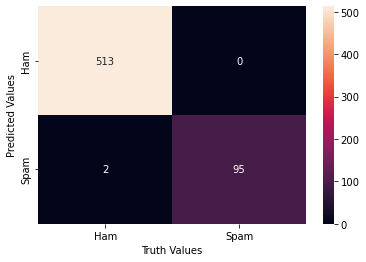

Accuracy: 99.67%
Precision: 100.00%
Recall: 97.94%
F1 score: 98.96%


In [14]:
# Choose optimal Bag of Words size of 10,750 from graph above

# Vectorise data into 16,000 size
vectorResults10750 = trainVectorise(processed, 10750)
# Get Vector
bow10750 = vectorResults10750[0]
#Get Vector Model
vectorContentModel10750 = vectorResults10750[1]
vectorFromModel10750 = vectorResults10750[2]
vectorSubjectModel10750 = vectorResults10750[3]

# Train Naive Bayes with Vector
resultNB10750 = trainNaiveBayes(bow10750, labels)
# Get Naive Bayes Model
model10750 = resultNB10750[2]

# Display metrics for new Naive Bayes Model
getMetrics(resultNB10750[0], resultNB10750[1])

In [15]:
# Use newly trained model to predict for any subject, content & from address
def Predict(name, subject, content, fromAddress):
    potentialResults = ["Ham", "Spam"]
    #Load test data into Data Frame
    manualdf = pd.DataFrame(columns=[ "content", "from", "subject", "label"], data=[[content, fromAddress, subject, "" ]])
    # Process Data Frame
    manualprocessed = processDf(manualdf)
    # Vectorise using 10750 size vectoriser previously trained
    manualBow = vectorise(manualprocessed, vectorContentModel10750, vectorFromModel10750, vectorSubjectModel10750)
    # Make prediction using previously trained model
    y_pred = model10750.predict(manualBow)
    # Print prediction
    print(name + " was predicted to be: " + potentialResults[y_pred[0]])


# Manually test Spam Email
spamSubject = "Free Iphone"
spamContent = "You've won a free Iphone, click here to redeem. Or send over your credit card number to pay for postage of your free gift"
spamFrom = "test@gmail.com"

# Manually test Ham Email
hamSubject = "Meeting"
hamContent = "Hi George, just a quick email to check you are doing okay and that all went well in your meeting today. Hopefully we can catch up tomorrow afternoon?"
hamFrom = "ryangaudion@email.com"

# Make predictions
Predict("Test 1", spamSubject, spamContent, spamFrom)
Predict("Test 2", hamSubject, hamContent, hamFrom)

IntProgress(value=0, max=1)

Test 1 was predicted to be: Spam


IntProgress(value=0, max=1)

Test 2 was predicted to be: Ham


In [16]:
os.system('jupyter nbconvert --to html "06 - MultinomialNB Example with Optimal Pipeline.ipynb"')

0